# One-class SVM

>One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

[Scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.colors import ListedColormap

# Every scikit-learn import
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from Data import Data

In [111]:
data = Data()

columns = ["rrTime" + str(index) for index in range(15)]
columns.extend(["ppTime" + str(index) for index in range(15)])
columns.extend(["rpTime" + str(index) for index in range(15)])
columns.extend(["prTime" + str(index) for index in range(15)])

xx, yy = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
Xpred = np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(58)]).T
user_index = 1

## Extracting the data

In [112]:
# We select the data of the user
studiedUserData = data.table.loc[(data.table["user_id"] == user_index), columns].astype('float')
# We create a random boolean mask to select around 80% of the data
studiedUserMsk = np.random.rand(len(studiedUserData)) < 0.8
# We select the rest of the data. It will be used as outliers.
otherUsersData = data.table.loc[(data.table["user_id"] != user_index), columns].astype('float')

# Training and testing data are for training on and testing normal data
X_train = studiedUserData[studiedUserMsk]
X_test = studiedUserData[~studiedUserMsk]

# Abnormal data (used only for prediction)
X_outliers = otherUsersData

# Fitting a standard scaler (mean = 0, var = 1.0)
#scaler = StandardScaler()

# According to https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
# data for SVM should be linearly scaled to the range [0, 1] or [-1, 1]
# Also, the scaler should be fitted on the training data only before transforming
# the rest of the data
scaler = MinMaxScaler((0, 1))
scaler.fit(X_train)

# Scaling the data. We use the scaler that have been fitted to the training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_outliers = scaler.transform(X_outliers)

In [113]:
# Fit the One Class SVM model
clf = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.01)
clf.fit(X_train)

# Predict on all data
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# Some metrics
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

print("False negative on training data : {0}/{1}, {2:.3f}%".format(n_error_train,
                                                                  X_train.shape[0],
                                                                  n_error_train / X_train.shape[0] * 100))
print("False negative on testing data : {0}/{1}, {2:.3f}%".format(n_error_test,
                                                                 X_test.shape[0],
                                                                 n_error_test / X_test.shape[0] * 100))
print("False positive on abnormal data : {0}/{1}, {2:.3f}%".format(n_error_outliers,
                                                                  X_outliers.shape[0],
                                                                  n_error_outliers / X_outliers.shape[0] * 100))

False negative on training data : 3/43, 6.977%
False negative on testing data : 0/12, 0.000%
False positive on abnormal data : 94/3715, 2.530%


## Plotting the decision function

Apparently, this is not very significative. When the 60-dimensional points are projected on a 2-dimensional plane, abnormal data overlap the area included inside the decision function.

Plus, I do have issues for plotting the frontiers.

/media/data/rodolphe/Documents/Etudes/ISEN/AP4/Projet/data/env/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


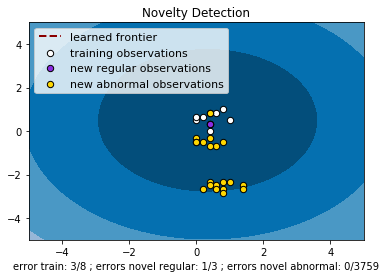

In [108]:
Z = clf.decision_function(Xpred)
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
#plt.contourf(xx, yy, Z, levels=np.linspace(0, Z.max(), 7), colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:20, 0], X_outliers[:20, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier",
            "training observations",
            "new regular observations",
            "new abnormal observations"],
           loc="upper left", prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel("error train: %d/%d ; errors novel regular: %d/%d ; errors novel abnormal: %d/%d" % (n_error_train, X_train.shape[0], n_error_test, X_test.shape[0], n_error_outliers, X_outliers.shape[0]))
plt.show()